In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 4 - Inferences with Gaussians
## 4.1 Inferring a mean and standard deviation


Inferring the mean and variance of a Gaussian distribution. 
$$ \mu \sim \text{Gaussian}(0, .001)  $$
$$ \sigma \sim \text{Uniform} (0, 10)  $$
$$ x_{i} \sim \text{Gaussian} (\mu, \frac{1}{\sigma^2})  $$


In [3]:
# Data
x = np.array([1.1, 1.9, 2.3, 1.8])
n = len(x)

with pm.Model() as model1:
    # prior
    mu = pm.Normal("mu", mu=0., tau=0.001)
    sigma = pm.Uniform("sigma", lower=0., upper=10.)
    # observed
    xi = pm.Normal("xi", mu=mu, tau=1 / (sigma ** 2), observed=x)
    # inference
    trace1 = pm.sample(2000, tune=2000, target_accept=0.9)
    idata1 = az.from_pymc3(trace1)
    
az.summary(idata1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 16000/16000 [00:16<00:00, 979.23draws/s]
The acceptance probability does not match the target. It is 0.8101145628582396, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.750,0.792,0.596,3.082,0.027,0.019,840.0,840.0,1725.0,946.0,1.0
sigma,1.035,0.971,0.247,2.608,0.037,0.026,702.0,702.0,1018.0,988.0,1.0


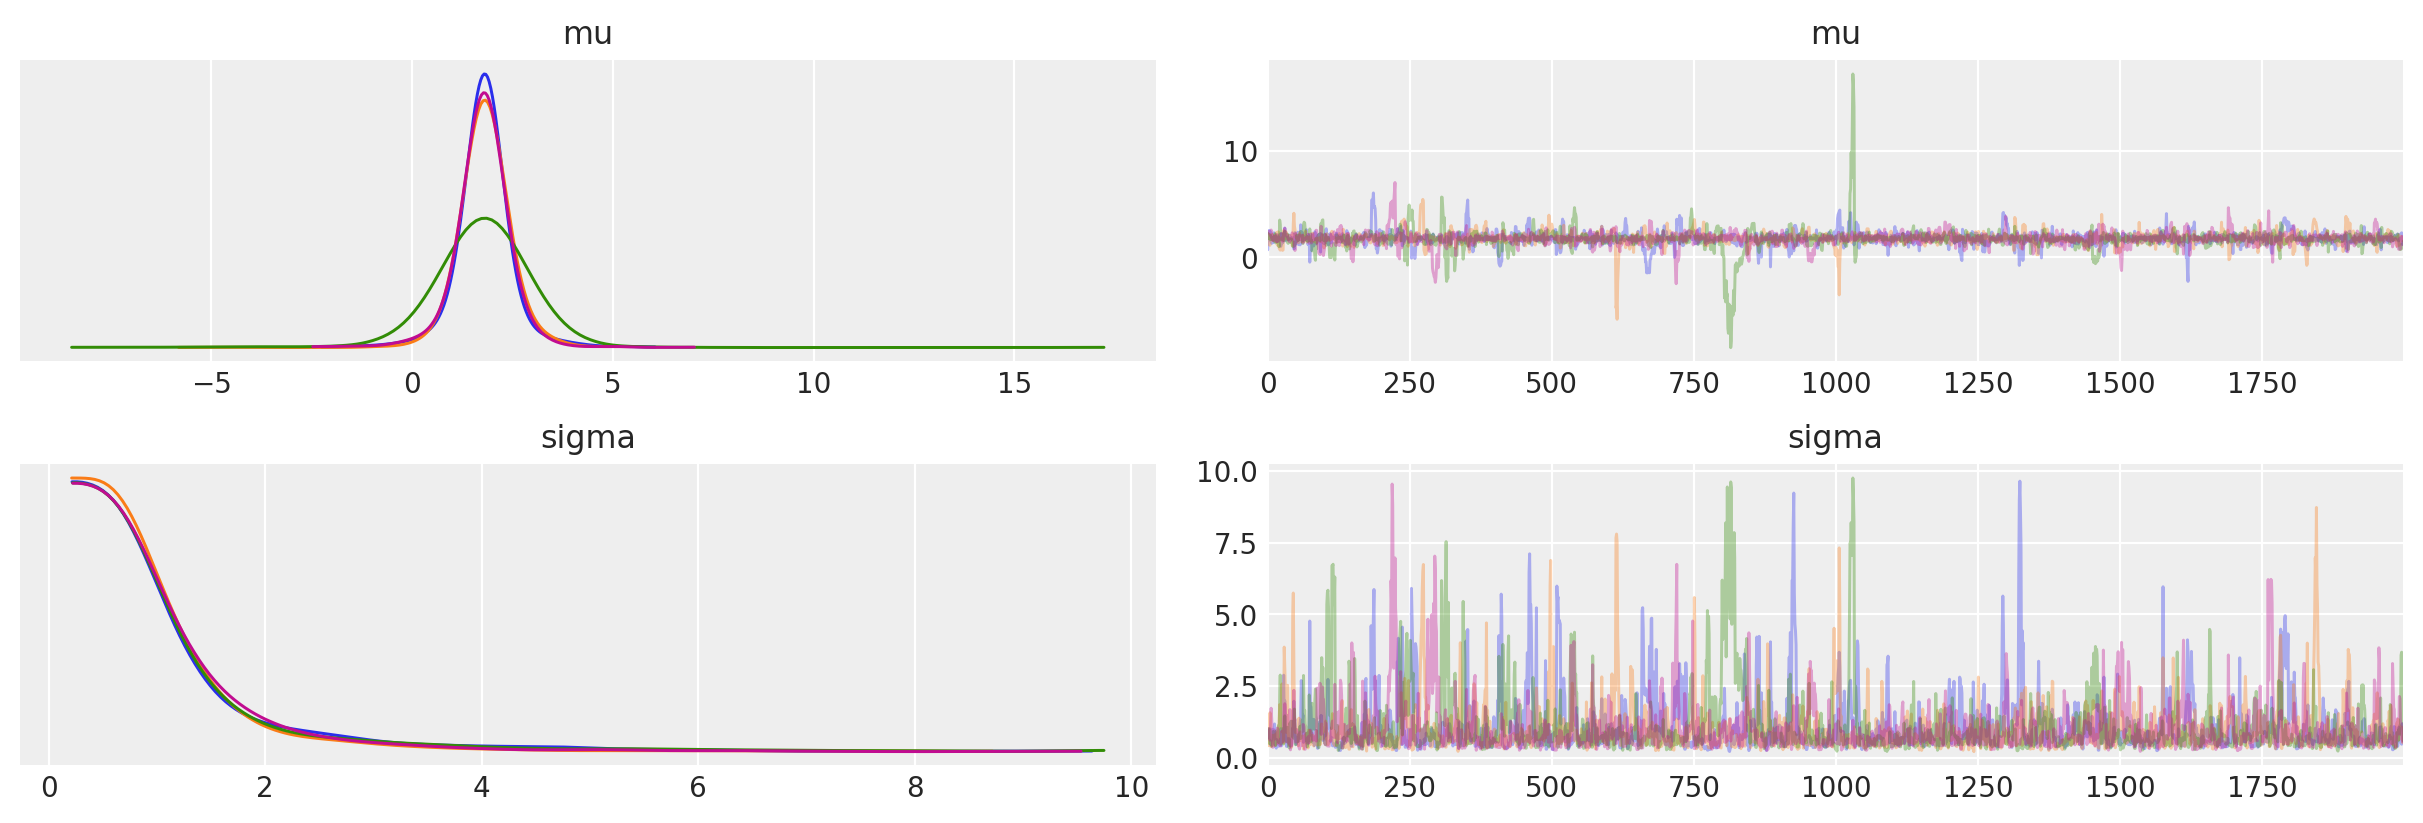

In [4]:
az.plot_trace(idata1);

D:\Anaconda3\lib\site-packages\arviz\plots\jointplot.py:149: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


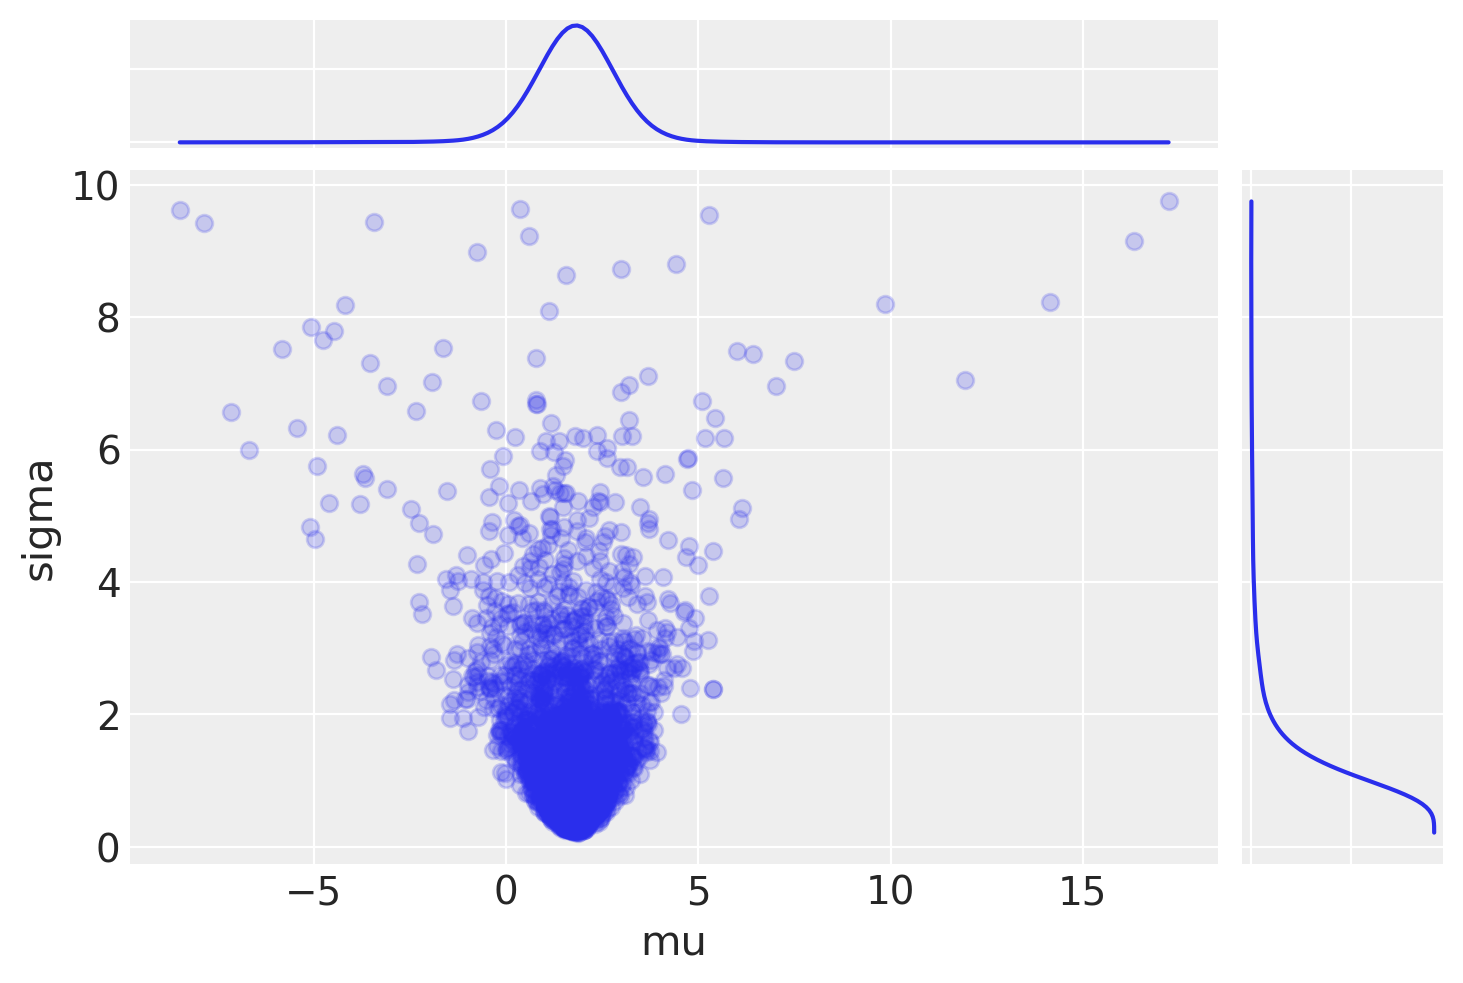

In [5]:
az.plot_joint(idata1, joint_kwargs={"alpha": 0.2});

### Note from Junpeng Lao
There might be divergence warning (Uniform prior on sigma is not a good idea in general), which you can further visualize below:

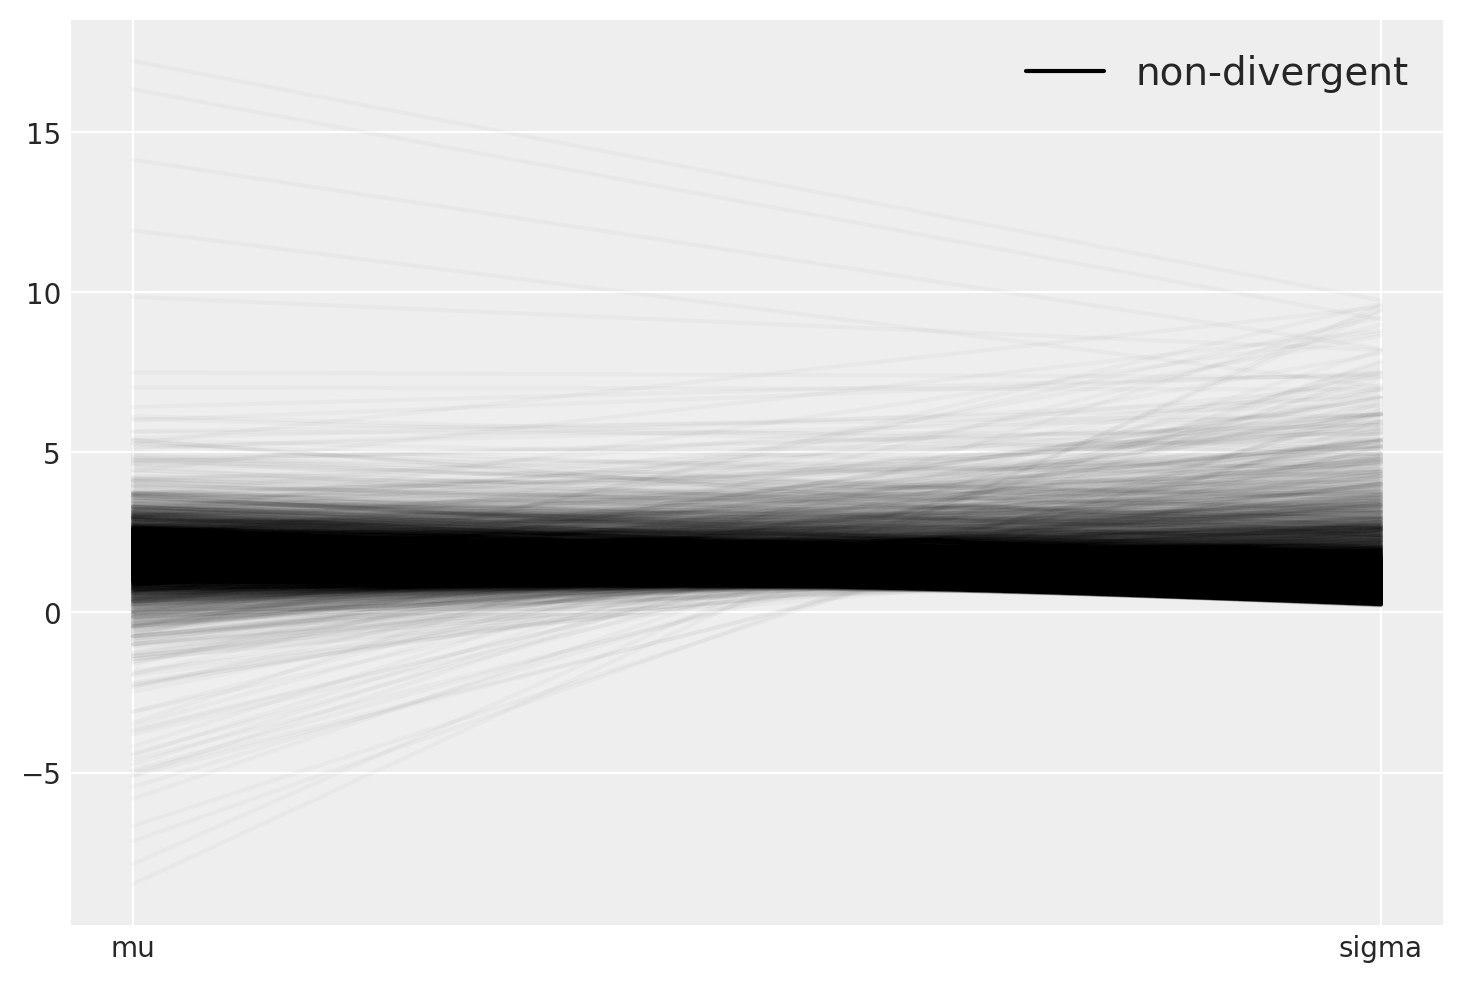

In [6]:
az.plot_parallel(idata1);

## 4.2 The seven scientists


The model:
$$ \mu \sim \text{Gaussian}(0, .001)  $$
$$ \lambda_{i} \sim \text{Gamma} (.001, .001)  $$
$$ \sigma = 1/{\sqrt\lambda_{i}} $$  
$$ x_{i} \sim \text{Gaussian} (\mu, \lambda_{i})  $$

The mean is the same for all seven scientists, while the standard deviations are different 

In [7]:
# data
x = np.array([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])
n = len(x)

with pm.Model() as model2:
    # prior
    mu = pm.Normal("mu", mu=0., tau=0.001)
    # shape告诉我们有7个科学家而不是一个科学家观察了7个样本
    lambda1 = pm.Gamma("lambda1", alpha=0.01, beta=0.01, shape=n)
    # sigma = pm.Deterministic('sigma',1 / sqrt(lambda1))
    # observed
    xi = pm.Normal("xi", mu=mu, tau=lambda1, observed=x)

    # inference
    trace2 = pm.sample(2000, tune=2000, target_accept=0.9)
    idata2 = az.from_pymc3(trace2)
    
az.summary(idata2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda1, mu]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 16000/16000 [00:25<00:00, 617.34draws/s]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,9.874,0.211,9.476,10.198,0.005,0.004,1555.0,1555.0,3116.0,2165.0,1.0
lambda1[0],0.001,0.001,0.000,0.003,0.000,0.000,7567.0,7567.0,3389.0,2246.0,1.0
lambda1[1],0.026,0.038,0.000,0.093,0.000,0.000,8481.0,6997.0,4121.0,2756.0,1.0
lambda1[2],0.437,2.712,0.000,1.340,0.044,0.031,3859.0,3859.0,3670.0,3043.0,1.0
lambda1[3],31.719,51.883,0.000,118.116,0.637,0.450,6636.0,6636.0,3310.0,2375.0,1.0
lambda1[4],14.326,29.793,0.000,55.083,0.381,0.270,6104.0,6104.0,4046.0,2905.0,1.0
lambda1[5],31.486,51.264,0.000,116.952,0.614,0.434,6975.0,6975.0,3198.0,2200.0,1.0
lambda1[6],24.554,44.123,0.000,92.002,0.542,0.383,6622.0,6622.0,3514.0,2811.0,1.0


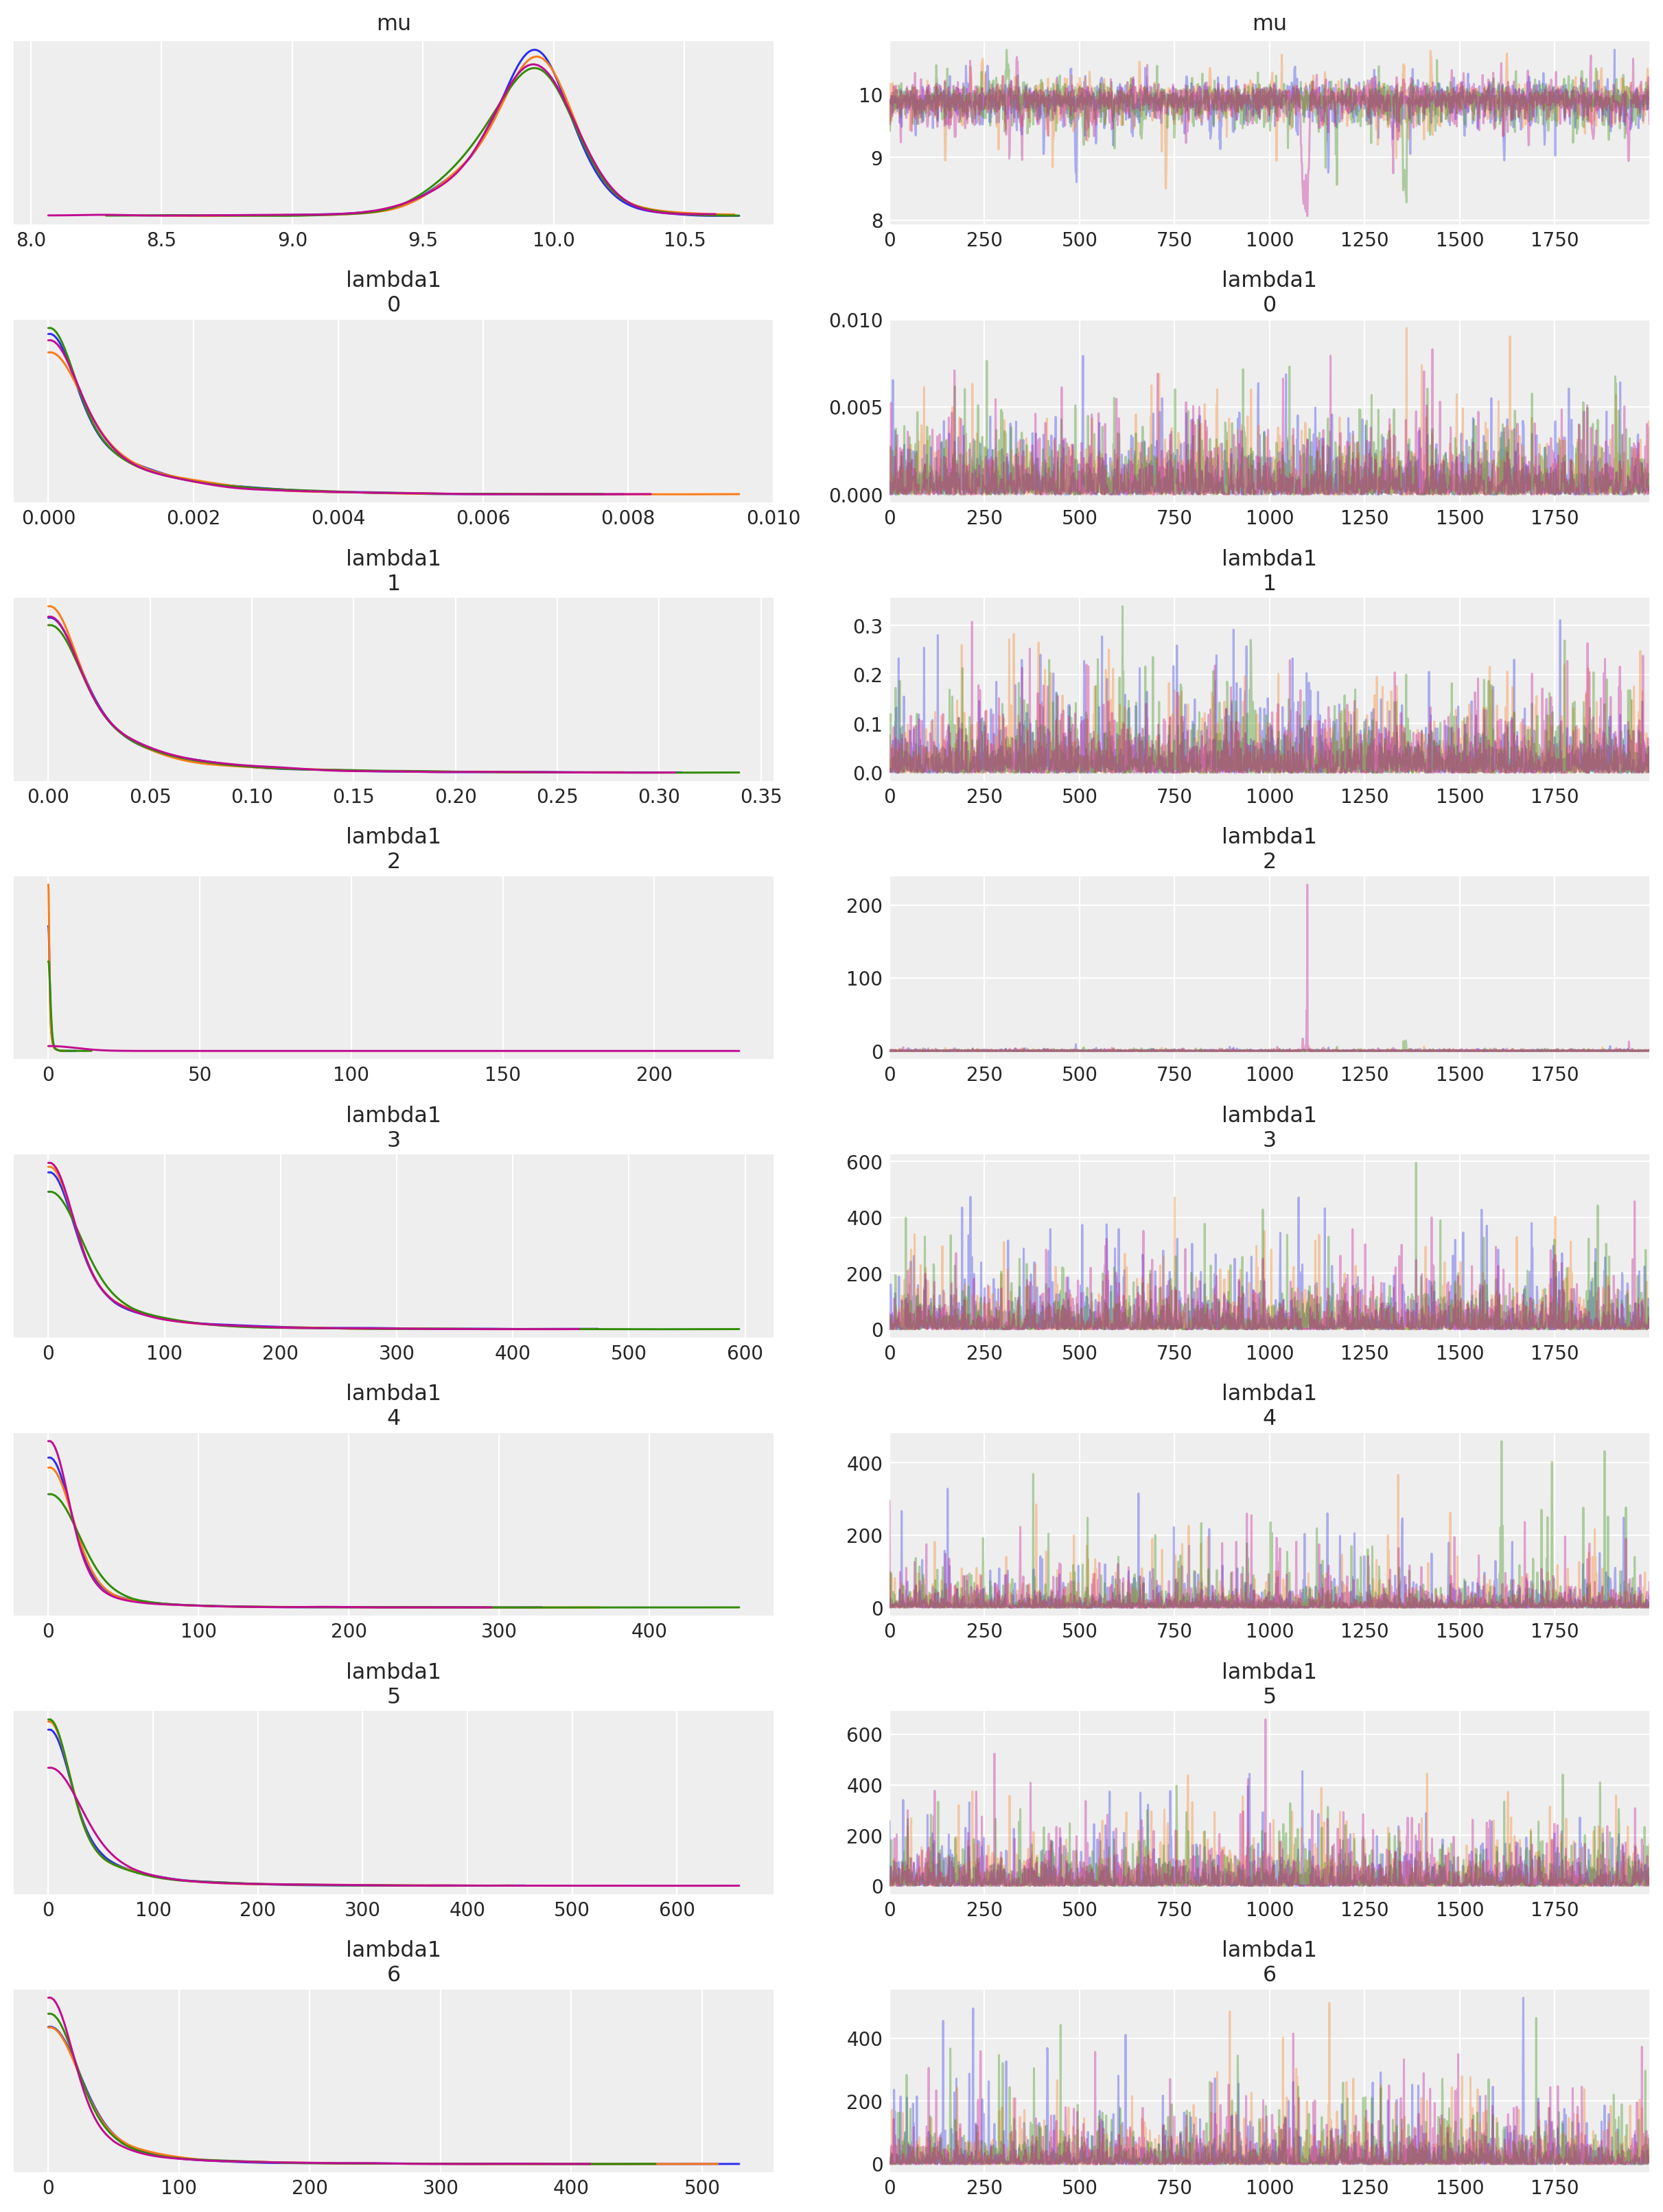

In [8]:
az.plot_trace(idata2);

## 4.3 Repeated measurement of IQ


The model:
$$ \mu_{i} \sim \text{Uniform}(0, 300)  $$
$$ \sigma \sim \text{Uniform} (0, 100)  $$
$$ x_{ij} \sim \text{Gaussian} (\mu_{i}, \frac{1}{\sigma^2})  $$

Data Come From Gaussians With Different Means But Common Precision

In [9]:
# Data, 3 people with 3 tests
y = np.array([[90, 95, 100], [105, 110, 115], [150, 155, 160]])
ntest = 3
nsbj = 3

with pm.Model() as model3:
    # mu_i ~ Uniform(0, 300)
    # notices the shape here need to be properly
    # initualized to have the right repeated measure
    mui = pm.Uniform("mui", 0., 300., shape=(nsbj, 1))

    # sigma ~ Uniform(0, 100)
    #sg = pm.Uniform('sg', .0, 100)

    # It is more stable to use a Gamma prior
    lambda1 = pm.Gamma("lambda1", alpha=0.01, beta=0.01)
    sg = pm.Deterministic("sg", 1 / np.sqrt(lambda1))

    # y ~ Normal(mu_i, sg)
    yd = pm.Normal("y", mu=mui, sd=sg, observed=y)

    trace3 = pm.sample(init="adapt_diag")
    idata3 = az.from_pymc3(trace3)
    
az.summary(idata3)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda1, mui]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:08<00:00, 492.63draws/s]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mui[0,0]",95.043,3.511,88.249,101.412,0.090,0.064,1533.0,1509.0,1705.0,1050.0,1.0
"mui[1,0]",109.993,3.538,103.563,116.787,0.096,0.068,1356.0,1351.0,1593.0,958.0,1.0
"mui[2,0]",155.014,3.256,149.196,161.541,0.078,0.055,1748.0,1747.0,1790.0,1140.0,1.0
lambda1,0.041,0.025,0.005,0.087,0.001,0.001,748.0,748.0,687.0,1013.0,1.0
sg,5.686,2.044,2.725,9.105,0.080,0.057,650.0,650.0,687.0,1013.0,1.0


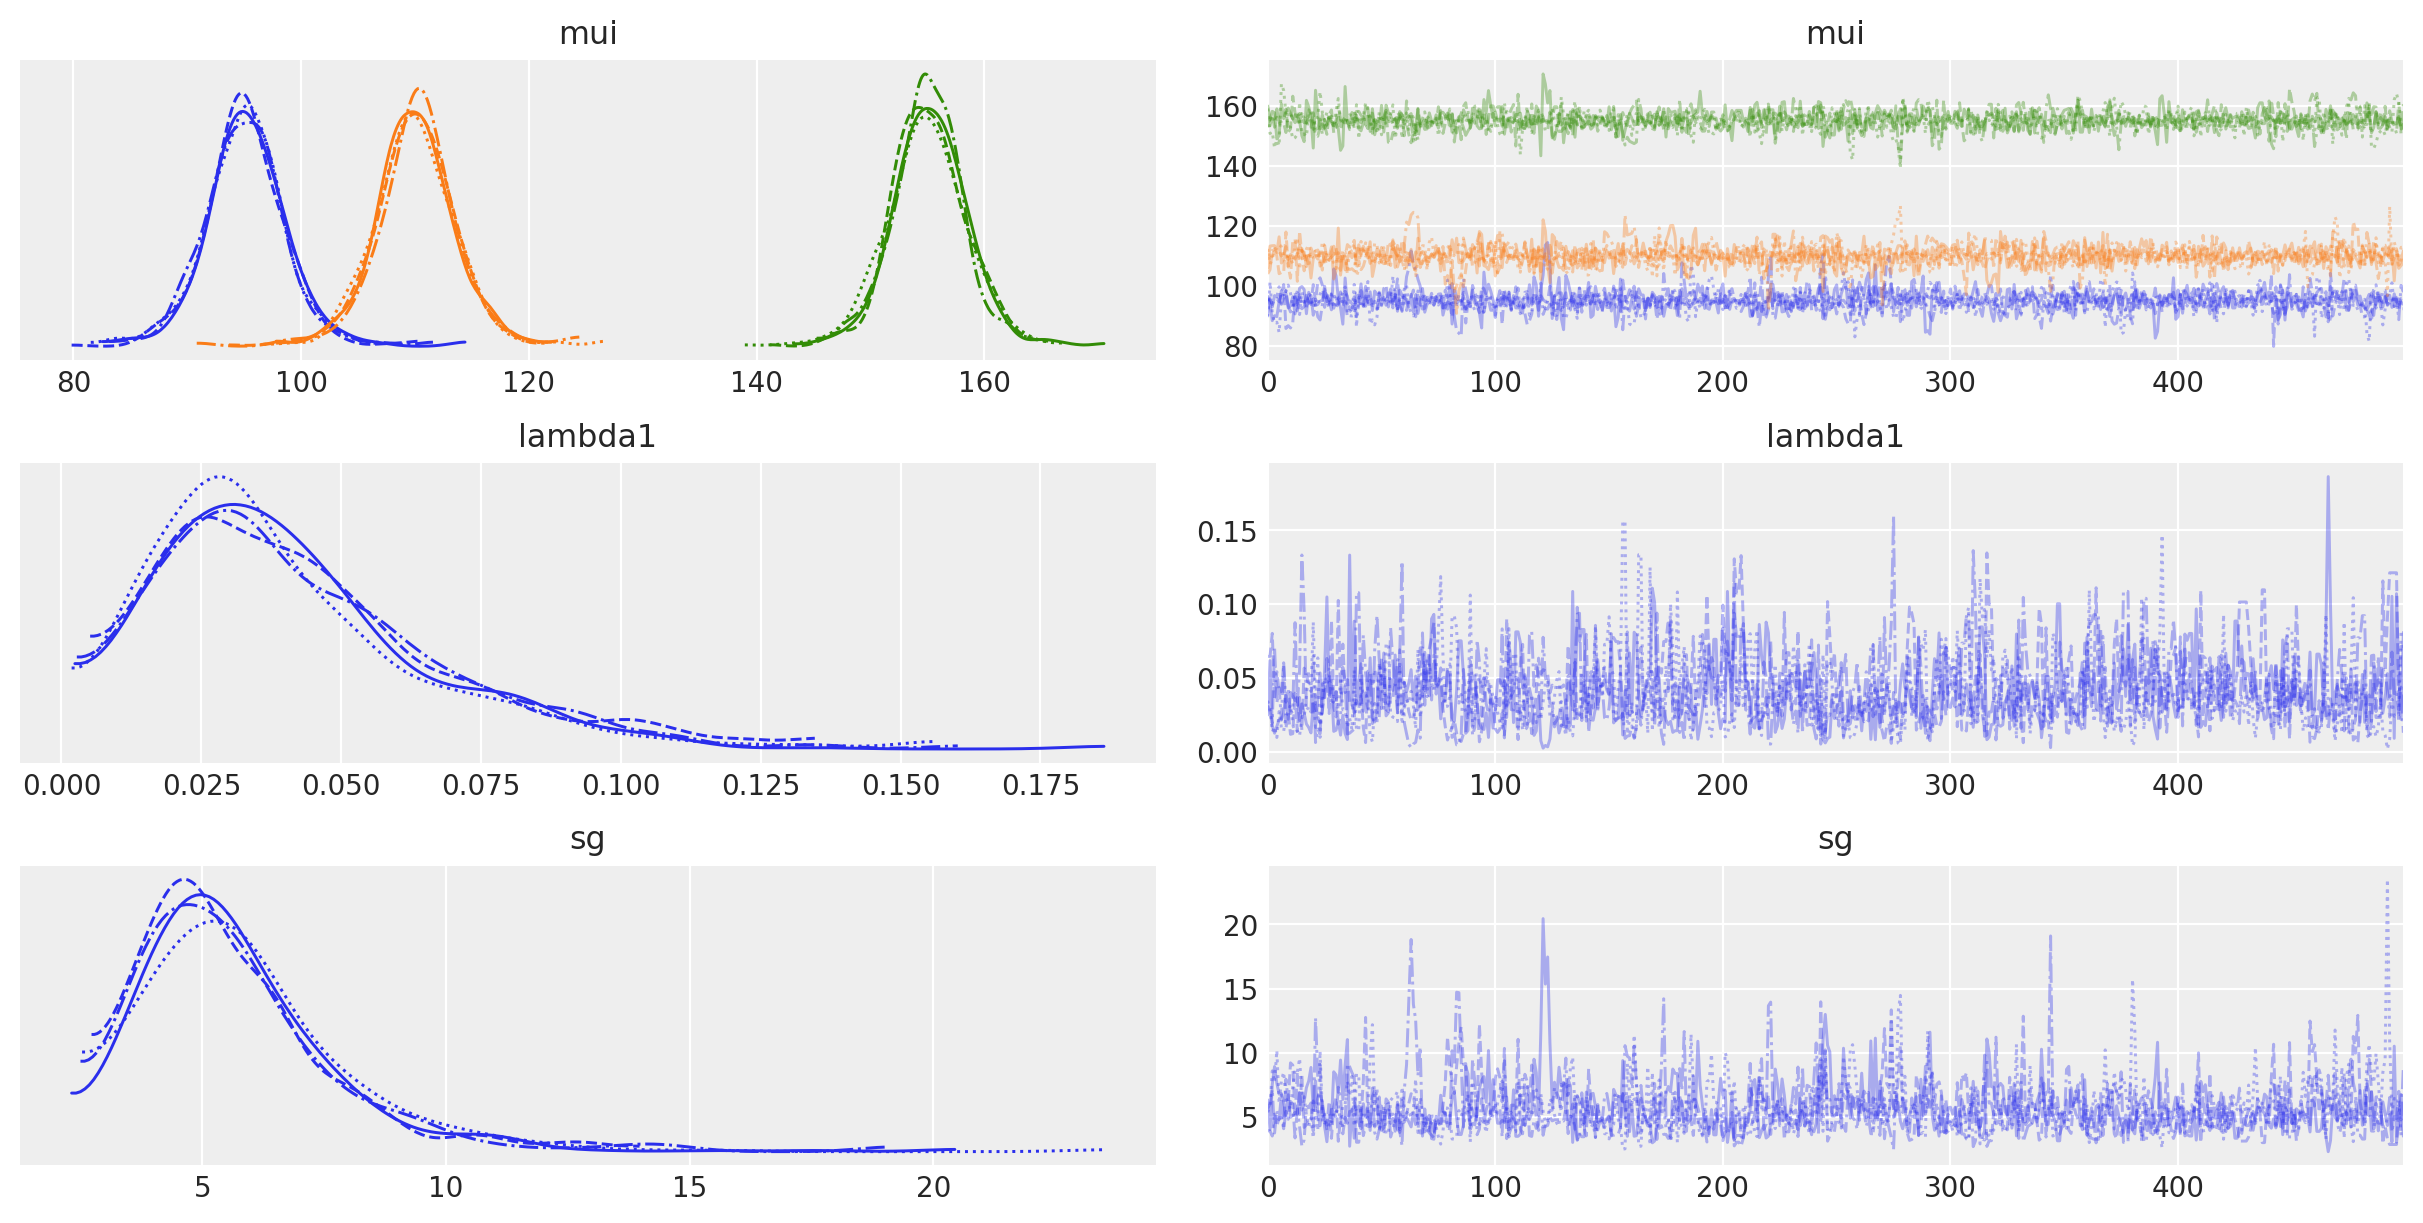

In [10]:
az.plot_trace(idata3, compact=True);

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz  0.7.0
pandas 1.0.3
pymc3  3.8
numpy  1.18.1
last updated: Sat Apr 25 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
